### CVEC EDA and Model Creation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier

In [57]:
nba_nfl = pd.read_csv('data/nba_nfl_modelling_data.csv')
nba_nfl.head()

,subreddit,title
0,nba,Why is it universally accepted that magic is b...
1,nba,Soo is anyone gonna talk about Ben?
2,nba,Theory on the KD Sweepstakes
3,nba,No matter what the Lakers try to do for LeBron...
4,nba,Adam silver is the worst commissioner in sports


In [3]:
nba_nfl['subreddit'] = nba_nfl['subreddit'].map({'nba': 0, 'nfl': 1})

nba_nfl.head()

,subreddit,title
0,0,Why is it universally accepted that magic is b...
1,0,Soo is anyone gonna talk about Ben?
2,0,Theory on the KD Sweepstakes
3,0,No matter what the Lakers try to do for LeBron...
4,0,Adam silver is the worst commissioner in sports


Converted the two categories nba and nfl in subreddit to binary labels.

In [4]:
X = nba_nfl['title']
y = nba_nfl['subreddit']

In [5]:
y.value_counts(normalize = True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

This gives us the baseline score, we want out model to atleast have a better score than 0.5.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,stratify=y,random_state=420)

In [7]:
cvec = CountVectorizer()
cvec.fit(X_train)
X_train=cvec.transform(X_train)
X_train.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [8]:
X_test = cvec.transform(X_test)

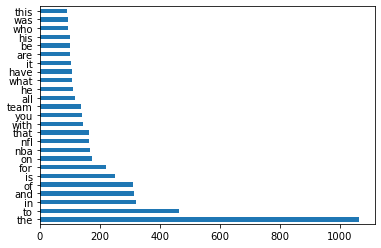

In [9]:
X_train_df = pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names())
X_train_df.sum().sort_values(ascending=False).head(25).plot(kind = 'barh');

These are the words that occur the most in title, most of them will be added to stop_words, but it is good that there are a lot of instances of nba and nfl this will help increase the model's score.

In [10]:
print(CountVectorizer(stop_words = 'english').get_stop_words())
k = list(CountVectorizer(stop_words = 'english').get_stop_words())

frozenset({'above', 'someone', 'top', 'up', 'etc', 'although', 'forty', 'without', 'former', 'hundred', 'your', 'much', 'eight', 'itself', 'should', 'hereafter', 'behind', 'anyhow', 'sixty', 'what', 'anywhere', 'by', 'herself', 'wherever', 'back', 'everywhere', 'upon', 'get', 'about', 'third', 'under', 'except', 'ever', 'put', 'most', 'my', 'of', 'noone', 'even', 'such', 'yourself', 'co', 'ten', 'themselves', 'call', 'anyway', 'every', 'move', 'throughout', 'twelve', 'yours', 'too', 'only', 'thence', 'after', 'been', 'its', 'was', 'fifteen', 'anything', 'amount', 'below', 'and', 'further', 'from', 'please', 'might', 'thereby', 'else', 'will', 'fire', 'hereupon', 're', 'amongst', 'sometime', 'off', 'otherwise', 'during', 'across', 'keep', 'onto', 'any', 'or', 'several', 'their', 'still', 'made', 'eleven', 'somehow', 'others', 'couldnt', 'herein', 'always', 'that', 'hence', 'but', 'they', 'whither', 'give', 'mill', 'he', 'afterwards', 'therefore', 'one', 'out', 'find', 'those', 'perhaps'

This shows us sklearn's stopwords, will look at this list to see what words to add to cvec parameters.

### First Model Creation

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,stratify=y,random_state=420)

In [92]:
pipe = Pipeline([('cvec', CountVectorizer()),('nb', MultinomialNB())])

Used MultinomialNB because it is a classifier that works well with discrete features like word_counts, to classify text.

In [93]:
pipe_params = {
    'cvec__max_features': [500, 1_000, 1_500, 2_000],
    'cvec__min_df': [50, 100],
    'cvec__max_df': [.85, .9],
    'cvec__ngram_range': [(1, 1), (1, 2),(1,3)]
}

In [94]:
gs = GridSearchCV(pipe, param_grid = pipe_params, cv = 5)

In [95]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9],
                         'cvec__max_features': [500, 1000, 1500, 2000],
                         'cvec__min_df': [50, 100],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [96]:
gs.best_score_

0.6921428571428573

In [97]:
gs.score(X_train, y_train)

0.7414285714285714

In [98]:
gs.score(X_test, y_test)

0.69

In [99]:
cross_val_score(gs, X_train, y_train, cv=3).mean()

0.6764144556463348

The best score, gs test score, and cross val score are all much higher than the baseline score. the test score was 0.19 higher than the baseline score and cross val score was 0.17 higher than the baseline score. This model was overfit, having training score being .05 higher than the testing score.

In [131]:
gs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 500,
 'cvec__min_df': 50,
 'cvec__ngram_range': (1, 1)}

This shows what parameters got the model to get the best score. I will look at stop_words next and then create another model with lower max_df, max_features and min_df.

In [100]:
preds = gs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

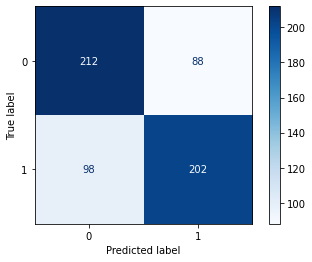

In [101]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

This shows how many y_test values were correctly labeled and how many y_test values were predicted wrongly. The model predicted 0, which is nba correctly 212 times and wrongly 98 times. The model predicted 1, which is nfl correctly 202 times and wrongly 88 times.

In [102]:
spec = tn / (tn + fp)
spec

0.7066666666666667

This specificity tells us how well the model is at predicting true negatives of the dataset. It predicts the true negatives 70% of the time.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,stratify=y,random_state=420)

In [122]:
pipe_params1 = {
    'cvec__max_features': [500, 1_000, 1_500, 2_000],
    'cvec__min_df': [50, 100],
    'cvec__max_df': [.85, .9],
    'cvec__ngram_range': [(1, 1), (1, 2),(1,3)],
    'cvec__stop_words' : [['this','was','who','his','be','are','it','have','what','he','all','team','you','with','that','on','for','is','of','and','in','the','to']]
}

I looked at the 25 words that were used the most and added them to stop_words, except for nba and nfl because I believe those two words would help the model differentiate between the two subreddits.

In [123]:
gs1 = GridSearchCV(pipe, param_grid = pipe_params1, cv = 5)

In [124]:
gs1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9],
                         'cvec__max_features': [500, 1000, 1500, 2000],
                         'cvec__min_df': [50, 100],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cvec__stop_words': [['this', 'was', 'who', 'his',
                                               'be', 'are', 'it', 'have',
                                               'what', 'he', 'all', 'team',
                                               'you', 'with', 'that', 'on',
                                               'for', 'is', 'of', 'and', 'in',
                                               'the', 'to']]})

In [130]:
gs1.best_score_

0.6699999999999999

In [177]:
gs1.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 500,
 'cvec__min_df': 50,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': ['this',
  'was',
  'who',
  'his',
  'be',
  'are',
  'it',
  'have',
  'what',
  'he',
  'all',
  'team',
  'you',
  'with',
  'that',
  'on',
  'for',
  'is',
  'of',
  'and',
  'in',
  'the',
  'to']}

In [129]:
gs1.score(X_train, y_train)

0.715

In [128]:
gs1.score(X_test,y_test)

0.7016666666666667

In [110]:
cross_val_score(gs1, X_train, y_train, cv=3).mean()

/Users/prathikchukkapalli/opt/miniconda3/envs/dsi/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/prathikchukkapalli/opt/miniconda3/envs/dsi/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/prathikchukkapalli/opt/miniconda3/envs/dsi/lib/python3.9/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/Users/prathikchukkapalli/opt/miniconda3/envs/dsi/lib/python3.9/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/Users/prathikchukkapalli/opt/miniconda3/envs/dsi/lib/python3.9/site-packages/joblib/memory.py", line 349, in __call__
    return self.func(*args, **k

0.6464374006304509

The best score, and cross val score of this new model were worse than the first model created. The test score of this model was higher than the first model. This model was also less overfit than the first model.

In [125]:
preds = gs1.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

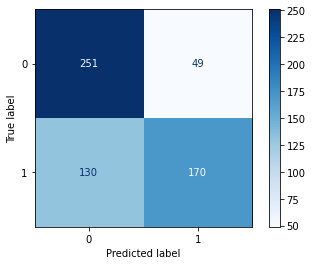

In [126]:
plot_confusion_matrix(gs1, X_test, y_test, cmap='Blues', values_format='d');

This shows how many y_test values were correctly labeled and how many y_test values were predicted wrongly. The model predicted 0, which is nba correctly 251 times and wrongly 130 times. The model predicted 1, which is nfl correctly 170 times and wrongly 49 times.

In [127]:
spec = tn / (tn + fp)
spec

0.8366666666666667

This model predicts true negatives correctly 83% of the time and is a higher percentage than the first model.

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,stratify=y,random_state=420)

In [166]:
pipe_params2 = {
    'cvec__max_features': [235, 250],
    'cvec__min_df': [3, 5],
    'cvec__max_df': [.45, .50],
    'cvec__ngram_range': [(1, 1)]
}

Took out the stop_words parameter and fine-tuned the parameters values.

In [167]:
gs2 = GridSearchCV(pipe, param_grid = pipe_params2, cv = 5)

In [168]:
gs2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.45, 0.5],
                         'cvec__max_features': [235, 250],
                         'cvec__min_df': [3, 5],
                         'cvec__ngram_range': [(1, 1)]})

In [169]:
gs2.best_score_

0.8299999999999998

In [170]:
gs2.best_params_

{'cvec__max_df': 0.5,
 'cvec__max_features': 250,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

In [171]:
gs2.score(X_train,y_train)

0.8628571428571429

In [172]:
gs2.score(X_test,y_test)

0.8033333333333333

In [173]:
cross_val_score(gs2, X_train, y_train, cv=3).mean()

0.8193028891074127

This model had the highest scores for best score, train score, test score, and cross val score. The model is still over fit with the training score being .06 higher than the testing score.

In [174]:
preds = gs2.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

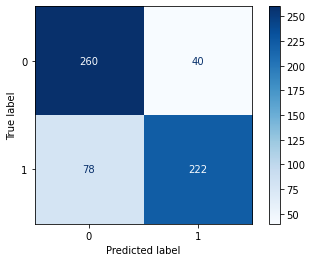

In [178]:
plot_confusion_matrix(gs2, X_test, y_test, cmap='Blues', values_format='d');

This shows how many y_test values were correctly labeled and how many y_test values were predicted wrongly. The model predicted 0, which is nba correctly 260 times and wrongly 78 times. The model predicted 1, which is nfl correctly 222 times and wrongly 40 times.

In [176]:
spec = tn / (tn + fp)
spec

0.8666666666666667

This model predicts true negatives correctly 86.66% of the time and is the highest result of all the models.

### Second Model Creation

In [188]:
pipe_params_knn = {
    'cvec__max_features': [235, 250],
    'cvec__min_df': [3, 5],
    'cvec__max_df': [.45, .50],
    'cvec__ngram_range': [(1, 1)]
}


In [220]:
def neighbors_model(params_for_knn):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,stratify=y,random_state=420)
    pipe_knn = Pipeline([('cvec', CountVectorizer()),('knn', KNeighborsClassifier())])
    gs_knn = GridSearchCV(pipe_knn, param_grid = params_for_knn, cv = 5)
    gs_knn.fit(X_train,y_train)
    print('best params = ', gs_knn.best_params_)
    print('best score = ', gs_knn.best_score_)
    print('training score = ', gs_knn.score(X_train,y_train))
    print('testing score = ', gs_knn.score(X_test,y_test))
    print('cross val score = ', cross_val_score(gs_knn, X_train, y_train, cv=3).mean())
    preds = gs_knn.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print('specificity = ',  (tn / (tn + fp)))
    plot_confusion_matrix(gs_knn, X_test, y_test, cmap='Blues', values_format='d');
    
    
    
    

best params =  {'cvec__max_df': 0.5, 'cvec__max_features': 250, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 1)}
best score =  0.6857142857142857
training score =  0.8157142857142857
testing score =  0.705
cross val score =  0.678560378393116
specificity =  0.7033333333333334


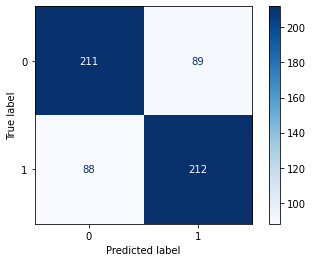

In [221]:
neighbors_model(pipe_params_knn)

This knn model is overfit and has lower scores than the MultinomialNB. Based on the best params I will look at increasing all parameters.

In [209]:
pipe_params_knn1 = {
    'cvec__max_features': [250, 300, 400, 500],
    'cvec__min_df': [5, 10, 15],
    'cvec__max_df': [.5, .55],
    'cvec__ngram_range': [(1, 1),(1,2),(1,3)]
}

best params =  {'cvec__max_df': 0.5, 'cvec__max_features': 250, 'cvec__min_df': 10, 'cvec__ngram_range': (1, 1)}
best score =  0.6957142857142856
training score =  0.825
testing score =  0.7233333333333334
cross val score =  0.6857226444630292
specificity =  0.7466666666666667


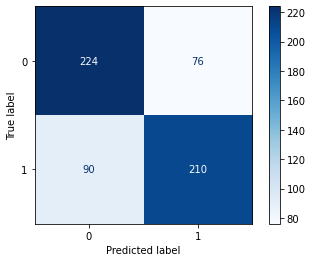

In [222]:
neighbors_model(pipe_params_knn1)

This model had improved scores than the above model. Based on the improvement of scores I will look to improve parameters as well as add knn parameters to the model. The model is still overfit and has lower scores than MultinomialNB.

In [212]:
pipe_params_knn2 = {
    'cvec__max_features': [250, 270],
    'cvec__min_df': [8, 10, 13],
    'cvec__max_df': [.5],
    'cvec__ngram_range': [(1, 1)],
    'knn__n_neighbors' : [3,5,10,15],
    'knn__weights' : ['uniform', 'distance']
}

best params =  {'cvec__max_df': 0.5, 'cvec__max_features': 270, 'cvec__min_df': 8, 'cvec__ngram_range': (1, 1), 'knn__n_neighbors': 10, 'knn__weights': 'distance'}
best score =  0.7078571428571429
training score =  0.9857142857142858
testing score =  0.7383333333333333
cross val score =  0.6814216087221574
specificity =  0.7966666666666666


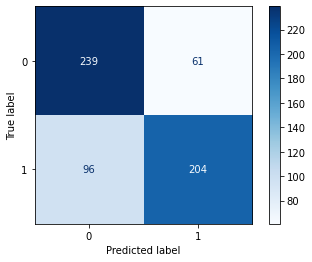

In [223]:
neighbors_model(pipe_params_knn2)

I added two knn parameters, and improved cvec parameters leading to sligt increase in scores, but the model now is even more overfit.

In [229]:
pipe_params_knn3 = {
    'cvec__max_features': [270, 290],
    'cvec__min_df': [6, 8, 10],
    'cvec__max_df': [.5],
    'cvec__ngram_range': [(1, 1)],
    'knn__n_neighbors' : [8,10,13],
    'knn__weights' : ['distance']
}

best params =  {'cvec__max_df': 0.5, 'cvec__max_features': 290, 'cvec__min_df': 8, 'cvec__ngram_range': (1, 1), 'knn__n_neighbors': 8, 'knn__weights': 'distance'}
best score =  0.707857142857143
training score =  0.9864285714285714
testing score =  0.7133333333333334
cross val score =  0.7028547971559248
specificity =  0.7733333333333333


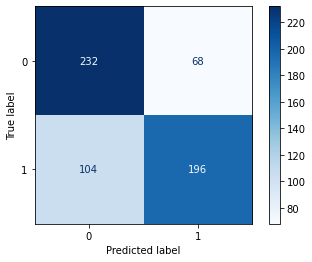

In [230]:
neighbors_model(pipe_params_knn3)

Changed knn parameter n_neighbors, but the scores for this model were lower than the other model. 

In [251]:
pipe_params_knn5 = {
    'cvec__max_features': [370],
    'cvec__min_df': [8],
    'cvec__max_df': [.5],
    'cvec__ngram_range': [(1, 1)],
    'cvec__stop_words' : [None,'english'],
    'knn__n_neighbors' : [8,9],
    'knn__weights' : ['distance']
}

best params =  {'cvec__max_df': 0.5, 'cvec__max_features': 370, 'cvec__min_df': 8, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'knn__n_neighbors': 8, 'knn__weights': 'distance'}
best score =  0.7535714285714286
training score =  0.9621428571428572
testing score =  0.7616666666666667
cross val score =  0.7693002852040082
specificity =  0.8866666666666667


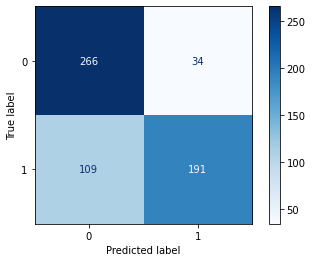

In [252]:
neighbors_model(pipe_params_knn5)

Added a cvec parameter stop_words using 'english' which is the stop_words generated by CountVectorizer.

In [253]:
pipe_params_log = {
    'cvec__max_features': [500,1_000,1_500,2_000],
    'cvec__min_df': [5,10,15,20],
    'cvec__max_df': [.5,.6],
    'cvec__ngram_range': [(1, 1),(1, 2)],
    'cvec__stop_words' : [None,'english']
}

In [11]:
def log_model(params_for_log):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,stratify=y,random_state=420)
    pipe_log = Pipeline([('cvec', CountVectorizer()),('log', LogisticRegression())])
    gs_log = GridSearchCV(pipe_log, param_grid = params_for_log, cv = 5)
    gs_log.fit(X_train,y_train)
    print('best params = ', gs_log.best_params_)
    print('best score = ', gs_log.best_score_)
    print('training score = ', gs_log.score(X_train,y_train))
    print('testing score = ', gs_log.score(X_test,y_test))
    print('cross val score = ', cross_val_score(gs_log, X_train, y_train, cv=3).mean())
    preds = gs_log.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    print('specificity = ',  (tn / (tn + fp)))
    plot_confusion_matrix(gs_log, X_test, y_test, cmap='Blues', values_format='d');

best params =  {'cvec__max_df': 0.5, 'cvec__max_features': 1000, 'cvec__min_df': 5, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english'}
best score =  0.8535714285714286
training score =  0.9514285714285714
testing score =  0.9033333333333333
cross val score =  0.8400177065431498
specificity =  0.9433333333333334


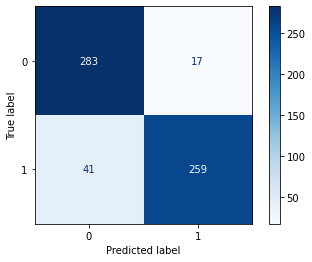

In [254]:
log_model(pipe_params_log)

Created a logistic regression model with 5 Count Vectorizer parameters that did very well, with the highest scores so far. Based on results I will be changing max_features, decreasing min_df and max_df. min_df means that words will only be used if they are present in atleast that many documents. max_df ignores words that are in greater than that many documents. The model is a little underfit, the training score is .05 higher than the testing score.

In [258]:
pipe_params_log1 = {
    'cvec__max_features': [900,1_000,1_100],
    'cvec__min_df': [3,4,5,6],
    'cvec__max_df': [.3,.4,.5],
    'cvec__ngram_range': [(1, 1),(1, 2)],
    'cvec__stop_words' : [None,'english']
}

best params =  {'cvec__max_df': 0.3, 'cvec__max_features': 1000, 'cvec__min_df': 3, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
best score =  0.8757142857142858
training score =  0.9735714285714285
testing score =  0.92
cross val score =  0.8550100633208039
specificity =  0.9433333333333334


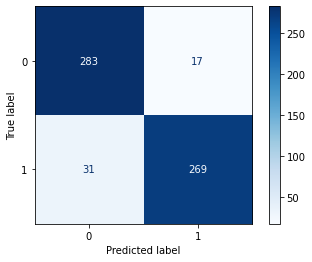

In [257]:
log_model(pipe_params_log1)

Improving the same parameters increased the scores for the logistic regression model. I will decrease min_df and max_df. This model is as underfit as the first logistic regression model.

In [259]:
pipe_params_log2 = {
    'cvec__max_features': [900,1_000,1_100],
    'cvec__min_df': [2,3,4,5,],
    'cvec__max_df': [.2,.3,.4,],
    'cvec__ngram_range': [(1, 1),(1, 2)],
    'cvec__stop_words' : [None,'english']
}

best params =  {'cvec__max_df': 0.2, 'cvec__max_features': 1100, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english'}
best score =  0.8807142857142857
training score =  0.9764285714285714
testing score =  0.92
cross val score =  0.8628753833098982
specificity =  0.9466666666666667


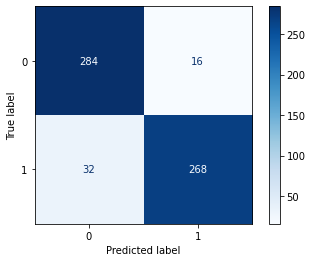

In [260]:
log_model(pipe_params_log2)

Changing same parameters did not have much effect on training and test scores, but best score and cross val score did improve because of the decrease in min_df and max_df. The model is still as underfit as the previous model.

In [30]:
pipe_params_log3 = {
    'cvec__max_features': [1_100,1_200,1_300],
    'cvec__min_df': [2,3,4,5,],
    'cvec__max_df': [.2,.3,.4,],
    'cvec__ngram_range': [(1, 1),(1, 2)],
    'cvec__stop_words' : [None,'english'],
    'log__max_iter' : [45,50]
}

best params =  {'cvec__max_df': 0.2, 'cvec__max_features': 1200, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'log__max_iter': 45}
best score =  0.8821428571428571
training score =  0.9764285714285714
testing score =  0.93
cross val score =  0.8657304868074
specificity =  0.95


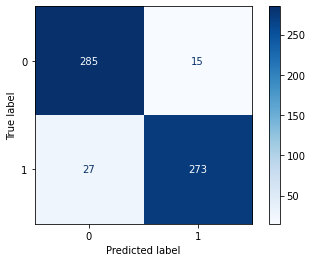

In [31]:
log_model(pipe_params_log3)

Adding logistic regression parameter max_iteration which states the maximum amount of iteration the model takes to converge the solvers improved best score,testing score, and cross val score. The model is still underfit, but less than the previous model.

In [53]:
pipe_params_log4 = {
    'cvec__max_features': [1_100,1_200,1_300],
    'cvec__min_df': [2,3,4,5,],
    'cvec__max_df': [.2,.3,.4,],
    'cvec__ngram_range': [(1, 1),(1, 2)],
    'cvec__stop_words' : [None,'english'],
    'log__max_iter' : [100,200],
    'log__fit_intercept' : [True,False],
    'log__multi_class' : ['auto','ovr','multinomial']
}

best params =  {'cvec__max_df': 0.2, 'cvec__max_features': 1200, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': 'english', 'log__fit_intercept': False, 'log__max_iter': 100, 'log__multi_class': 'auto'}
best score =  0.8878571428571428
training score =  0.9771428571428571
testing score =  0.9266666666666666
cross val score =  0.8714422255102886
specificity =  0.9433333333333334


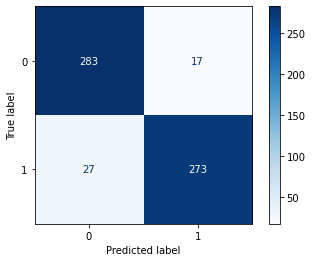

In [54]:
log_model(pipe_params_log4)

Added logistic regression parameters fit_intercept and multi_class. The multi_class parameter answer for best params was same as the default. Best params for fit_intercept was different than the default of true. This parameter decides if an intercept should be added to the function, it is better for an intercept not to be added. This model is just a little bit more overfit than the previous model, but has a better training score, best score, and cross val score. The specificity of this model is .007 lower than the previous one.

### Conclusion

Based on models created and the scores of those models, Logitic Regression with Count Vectorizer is the best model for the data and the purpose of the model and goal of the model. I have chosen the last Logistic Regression model which had a better best score and cross val score because even though it had a lower test score than a different Logistic Regression model cross val score is a better indicator on how the model will do on new data.